In [1]:
import generation as gen
import files
import utils
import os
import models
import numpy as np
from tqdm.autonotebook import tqdm
import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
import matplotlib.pyplot as plt
from matplotlib import cm

/Users/mzaffran/Documents/Code/CP/cp-epf-clean/models.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
size=19
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.serif': 'Times',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': size,
    'axes.labelsize':size,
    'axes.titlesize':size,
    'figure.titlesize':size,
    'xtick.labelsize':size,
    'ytick.labelsize':size,
    'legend.fontsize':size,
})

In [3]:
var = 10

list_params_noise_ar = [{'ar':[1,-0.1], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.8], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.9], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.95], 'ma':[1], 'process_variance':var},
                        {'ar':[1,-0.99], 'ma':[1], 'process_variance':var}]
list_params_noise_ma = [{'ar':[1], 'ma':[1,0.1], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.8], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.9], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.95], 'process_variance':var},
                        {'ar':[1], 'ma':[1,0.99], 'process_variance':var}]
list_params_noise_arma = [{'ar':[1,-0.1], 'ma':[1,0.1], 'process_variance':var},
                          {'ar':[1,-0.8], 'ma':[1,0.8], 'process_variance':var},
                          {'ar':[1,-0.9], 'ma':[1,0.9], 'process_variance':var},
                          {'ar':[1,-0.95], 'ma':[1,0.95], 'process_variance':var},
                          {'ar':[1,-0.99], 'ma':[1,0.99], 'process_variance':var}]

regression = 'Friedman'
noise = 'ARMA'
n = 400
train_size = 200
test_size = n-train_size
n_rep = 500
alpha = 0.1

tab_gamma = [0,
             0.000005,
             0.00005,
             0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
             0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
             0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]

warm_up = 50

In [4]:
optimize_gamma = True
methods = []
for gamma in tab_gamma:
    methods.append('ACP_'+str(gamma))
if optimize_gamma:
    methods.append('Aggregation_BOA_Gradient')
    methods.append('ACP_optimized_alpha')

In [5]:
noise_type = "ARMA"

In [6]:
if noise_type == "ARMA":
    list_params_noise = list_params_noise_arma
elif noise_type == "AR":
    list_params_noise = list_params_noise_ar
elif noise_type == "MA":
    list_params_noise = list_params_noise_ma

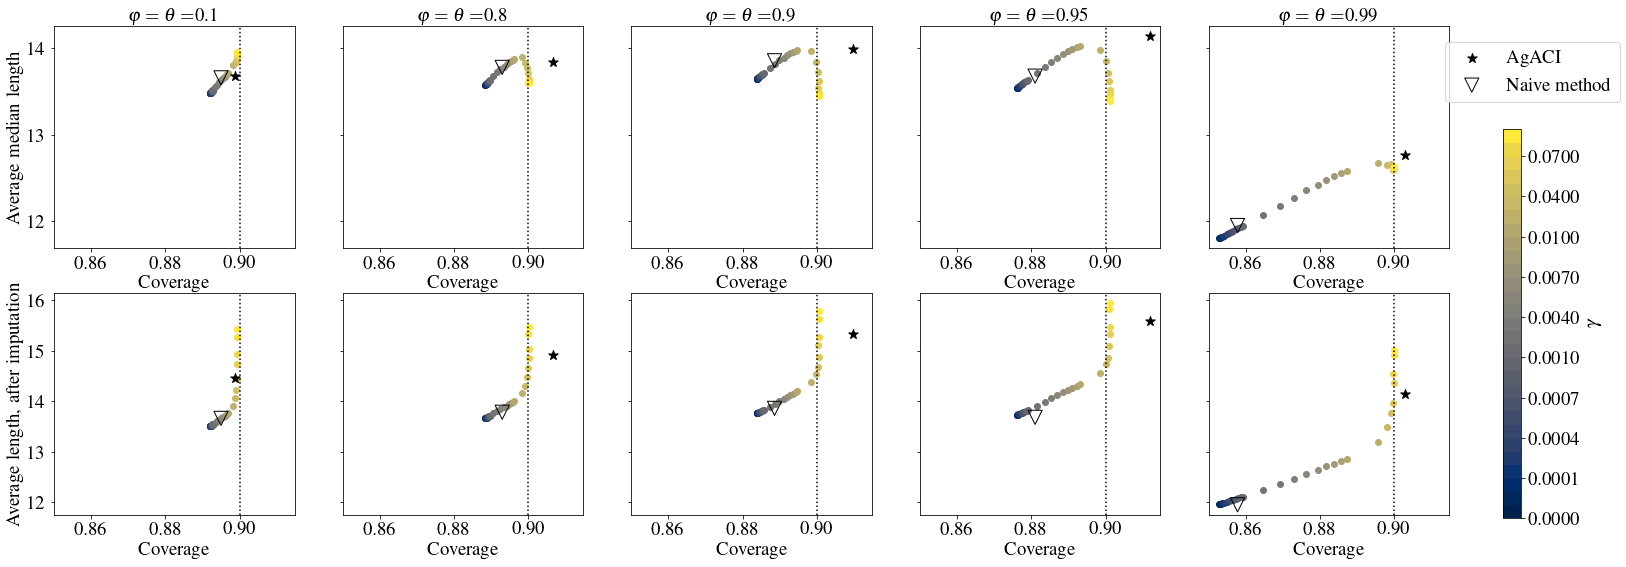

In [7]:
fig, ((ax6,ax7,ax8,ax9,ax10),(ax11,ax12,ax13,ax14,ax15)) = plt.subplots(2, 5, figsize=(25,9), sharey='row', sharex='row')

colors = cm.get_cmap('cividis', len(tab_gamma))

k = 0

params_noise = list_params_noise[0]
name = files.get_name_data(n, regression=regression, noise=noise, params_noise=params_noise, seed=n_rep)
if os.path.isfile('data/'+name+'.pkl'):
    data = files.load_file('data', name, 'pkl')
# Get values for imputation
name_dir, name_method = files.get_name_results('ACP_0', n, regression=regression, noise=noise,
                                               params_noise=params_noise)
results = files.load_file('results/'+name_dir, name_method, 'pkl')
borne_sup = results['Y_sup'][:n_rep,:]
borne_inf = results['Y_inf'][:n_rep,:]
y_chap = (borne_sup+borne_inf)/2
abs_res = np.abs(data['Y'][:n_rep,train_size:] - y_chap)
max_eps = np.max(abs_res)
val_max = y_chap+max_eps
val_min = y_chap-max_eps
for idm, method in enumerate(methods):
    name_dir, name_method = files.get_name_results(method, n, regression=regression, noise=noise,
                                                   params_noise=params_noise)
    results = files.load_file('results/'+name_dir, name_method, 'pkl')
    contains = (data['Y'][:n_rep,train_size:] <= results['Y_sup'][:n_rep,:]) & (data['Y'][:n_rep,train_size:] >= results['Y_inf'][:n_rep,:])
    lengths = results['Y_sup'][:n_rep,:] - results['Y_inf'][:n_rep,:]
    med_lengths = np.median(lengths, axis=1)
    borne_sup = results['Y_sup'][:n_rep,:]
    borne_inf = results['Y_inf'][:n_rep,:]
    borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
    borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
    borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
    borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
    lengths = borne_sup - borne_inf
    moy_lengths = np.mean(lengths, axis=1)
    if method not in ['Aggregation_EWA_Gradient','Aggregation_MLpol_Gradient','Aggregation_BOA_Gradient','ACP_optimized_alpha', 'ACP_optimized_gamma']:
        ax6.scatter(np.mean(contains),np.mean(med_lengths), 
                    color=colors(idm/len(tab_gamma)))
        ax11.scatter(np.mean(contains),np.mean(moy_lengths), 
                     color=colors(idm/len(tab_gamma)))
    elif method == 'ACP_optimized_alpha':
        results = utils.gamma_opt_warm_up(tab_gamma=tab_gamma,alpha=alpha,warm_up=warm_up,
                                          n=n,train_size=train_size,n_rep=n_rep,regression=regression,noise=noise,
                                          params_noise=params_noise)
        contains = results['contains']
        borne_sup = results['Y_sup'][:n_rep,:]
        borne_inf = results['Y_inf'][:n_rep,:]
        med_lengths = np.median(borne_sup-borne_inf, axis=1)
        borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
        borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
        borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
        borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
        lengths = borne_sup - borne_inf
        moy_lengths = np.median(lengths, axis=1)
        ax6.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = 'v',
                    color='black', facecolors='none',label='Naive method', s=200)
        ax11.scatter(np.mean(contains),np.mean(moy_lengths), 
                     marker = 'v',
                    color='black', facecolors='none', s=200)
    elif method == 'Aggregation_EWA_Gradient':
        ax6.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black',label='Aggregation EWA')
        ax11.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black')
    elif method == 'Aggregation_MLpol_Gradient':
        ax6.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "+",
                    color='black',label='Aggregation MLpol')
        ax11.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "+",
                    color='black')
    elif method == 'Aggregation_BOA_Gradient':
        ax6.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black',
                    label='AgACI', s=100)
        ax11.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black',s=100)
if noise_type == "ARMA":
    ax6.set_title(r'$\varphi = \theta = $'+str(-params_noise['ar'][1]))
elif noise_type == "AR":
    ax6.set_title(r'$\varphi = $'+str(-params_noise['ar'][1])+r'$, \theta = 0$')
elif noise_type == "MA":
    ax6.set_title(r'$\varphi = 0, \theta = $'+str(params_noise['ma'][1]))
ax6.axvline(x=1-alpha, color='black', ls=':')
ax6.set_xlabel("Coverage")
ax6.set_ylabel("Average median length")
ax11.axvline(x=1-alpha, color='black', ls=':')
ax11.set_xlabel("Coverage")
ax11.set_ylabel("Average length, after imputation")

params_noise = list_params_noise[1]
name = files.get_name_data(n, regression=regression, noise=noise, params_noise=params_noise, seed=n_rep)
if os.path.isfile('data/'+name+'.pkl'):
    data = files.load_file('data', name, 'pkl')
# Get values for imputation
name_dir, name_method = files.get_name_results('ACP_0', n, regression=regression, noise=noise,
                                               params_noise=params_noise)
results = files.load_file('results/'+name_dir, name_method, 'pkl')
borne_sup = results['Y_sup'][:n_rep,:]
borne_inf = results['Y_inf'][:n_rep,:]
y_chap = (borne_sup+borne_inf)/2
abs_res = np.abs(data['Y'][:n_rep,train_size:] - y_chap)
max_eps = np.max(abs_res)
val_max = y_chap+max_eps
val_min = y_chap-max_eps
for idm, method in enumerate(methods):
    name_dir, name_method = files.get_name_results(method, n, regression=regression, noise=noise,
                                                   params_noise=params_noise)
    results = files.load_file('results/'+name_dir, name_method, 'pkl')
    contains = (data['Y'][:n_rep,train_size:] <= results['Y_sup'][:n_rep,:]) & (data['Y'][:n_rep,train_size:] >= results['Y_inf'][:n_rep,:])
    lengths = results['Y_sup'][:n_rep,:] - results['Y_inf'][:n_rep,:]
    med_lengths = np.median(lengths, axis=1)
    borne_sup = results['Y_sup'][:n_rep,:]
    borne_inf = results['Y_inf'][:n_rep,:]
    borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
    borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
    borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
    borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
    lengths = borne_sup - borne_inf
    moy_lengths = np.mean(lengths, axis=1)
    if method not in ['Aggregation_EWA_Gradient','Aggregation_MLpol_Gradient','Aggregation_BOA_Gradient','ACP_optimized_alpha', 'ACP_optimized_gamma']:
        ax7.scatter(np.mean(contains),np.mean(med_lengths), 
                    color=colors(idm/len(tab_gamma)))
        ax12.scatter(np.mean(contains),np.mean(moy_lengths), 
                     color=colors(idm/len(tab_gamma)))
    elif method == 'ACP_optimized_alpha':
        results = utils.gamma_opt_warm_up(tab_gamma=tab_gamma,alpha=alpha,warm_up=warm_up,
                                          n=n,train_size=train_size,n_rep=n_rep,regression=regression,noise=noise,
                                          params_noise=params_noise)
        contains = results['contains']
        borne_sup = results['Y_sup'][:n_rep,:]
        borne_inf = results['Y_inf'][:n_rep,:]
        med_lengths = np.median(borne_sup-borne_inf, axis=1)
        borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
        borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
        borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
        borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
        lengths = borne_sup - borne_inf
        moy_lengths = np.median(lengths, axis=1)
        ax7.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = 'v',
                    color='black', facecolors='none', s=200)
        ax12.scatter(np.mean(contains),np.mean(moy_lengths), 
                     marker = 'v',
                    color='black', facecolors='none', s=200)
    elif method == 'Aggregation_EWA_Gradient':
        ax7.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black')
        ax12.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black')
    elif method == 'Aggregation_MLpol_Gradient':
        ax7.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "+",
                    color='black')
        ax12.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "+",
                    color='black')
    elif method == 'Aggregation_BOA_Gradient':
        ax7.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black', s=100)
        ax12.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black',s=100)
if noise_type == "ARMA":
    ax7.set_title(r'$\varphi = \theta = $'+str(-params_noise['ar'][1]))
elif noise_type == "AR":
    ax7.set_title(r'$\varphi = $'+str(-params_noise['ar'][1])+r'$, \theta = 0$')
elif noise_type == "MA":
    ax7.set_title(r'$\varphi = 0, \theta = $'+str(params_noise['ma'][1]))
ax7.axvline(x=1-alpha, color='black', ls=':')
ax7.set_xlabel("Coverage")
ax12.axvline(x=1-alpha, color='black', ls=':')
ax12.set_xlabel("Coverage")

params_noise = list_params_noise[2]
name = files.get_name_data(n, regression=regression, noise=noise, params_noise=params_noise, seed=n_rep)
if os.path.isfile('data/'+name+'.pkl'):
    data = files.load_file('data', name, 'pkl')
# Get values for imputation
name_dir, name_method = files.get_name_results('ACP_0', n, regression=regression, noise=noise,
                                               params_noise=params_noise)
results = files.load_file('results/'+name_dir, name_method, 'pkl')
borne_sup = results['Y_sup'][:n_rep,:]
borne_inf = results['Y_inf'][:n_rep,:]
y_chap = (borne_sup+borne_inf)/2
abs_res = np.abs(data['Y'][:n_rep,train_size:] - y_chap)
max_eps = np.max(abs_res)
val_max = y_chap+max_eps
val_min = y_chap-max_eps
for idm, method in enumerate(methods):
    name_dir, name_method = files.get_name_results(method, n, regression=regression, noise=noise,
                                                   params_noise=params_noise)
    results = files.load_file('results/'+name_dir, name_method, 'pkl')
    contains = (data['Y'][:n_rep,train_size:] <= results['Y_sup'][:n_rep,:]) & (data['Y'][:n_rep,train_size:] >= results['Y_inf'][:n_rep,:])
    lengths = results['Y_sup'][:n_rep,:] - results['Y_inf'][:n_rep,:]
    med_lengths = np.median(lengths, axis=1)
    borne_sup = results['Y_sup'][:n_rep,:]
    borne_inf = results['Y_inf'][:n_rep,:]
    borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
    borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
    borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
    borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
    lengths = borne_sup - borne_inf
    moy_lengths = np.mean(lengths, axis=1)
    if method not in ['Aggregation_EWA_Gradient','Aggregation_MLpol_Gradient','Aggregation_BOA_Gradient','ACP_optimized_alpha', 'ACP_optimized_gamma']:
        ax8.scatter(np.mean(contains),np.mean(med_lengths), 
                    color=colors(idm/len(tab_gamma)))
        ax13.scatter(np.mean(contains),np.mean(moy_lengths), 
                     color=colors(idm/len(tab_gamma)))
    elif method == 'ACP_optimized_alpha':
        results = utils.gamma_opt_warm_up(tab_gamma=tab_gamma,alpha=alpha,warm_up=warm_up,
                                          n=n,train_size=train_size,n_rep=n_rep,regression=regression,noise=noise,
                                          params_noise=params_noise)
        contains = results['contains']
        borne_sup = results['Y_sup'][:n_rep,:]
        borne_inf = results['Y_inf'][:n_rep,:]
        med_lengths = np.median(borne_sup-borne_inf, axis=1)
        borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
        borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
        borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
        borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
        lengths = borne_sup - borne_inf
        moy_lengths = np.median(lengths, axis=1)
        ax8.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = 'v',
                    color='black', facecolors='none', s=200)
        ax13.scatter(np.mean(contains),np.mean(moy_lengths), 
                     marker = 'v',
                    color='black', facecolors='none', s=200)
    elif method == 'Aggregation_EWA_Gradient':
        ax8.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black')
        ax13.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black')
    elif method == 'Aggregation_MLpol_Gradient':
        ax8.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "+",
                    color='black')
        ax13.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "+",
                    color='black')
    elif method == 'Aggregation_BOA_Gradient':
        ax8.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black', s=100)
        ax13.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black',s=100)
if noise_type == "ARMA":
    ax8.set_title(r'$\varphi = \theta = $'+str(-params_noise['ar'][1]))
elif noise_type == "AR":
    ax8.set_title(r'$\varphi = $'+str(-params_noise['ar'][1])+r'$, \theta = 0$')
elif noise_type == "MA":
    ax8.set_title(r'$\varphi = 0, \theta = $'+str(params_noise['ma'][1]))
ax8.axvline(x=1-alpha, color='black', ls=':')
ax8.set_xlabel("Coverage")
ax13.axvline(x=1-alpha, color='black', ls=':')
ax13.set_xlabel("Coverage")

params_noise = list_params_noise[3]
name = files.get_name_data(n, regression=regression, noise=noise, params_noise=params_noise, seed=n_rep)
if os.path.isfile('data/'+name+'.pkl'):
    data = files.load_file('data', name, 'pkl')
# Get values for imputation
name_dir, name_method = files.get_name_results('ACP_0', n, regression=regression, noise=noise,
                                               params_noise=params_noise)
results = files.load_file('results/'+name_dir, name_method, 'pkl')
borne_sup = results['Y_sup'][:n_rep,:]
borne_inf = results['Y_inf'][:n_rep,:]
y_chap = (borne_sup+borne_inf)/2
abs_res = np.abs(data['Y'][:n_rep,train_size:] - y_chap)
max_eps = np.max(abs_res)
val_max = y_chap+max_eps
val_min = y_chap-max_eps
for idm, method in enumerate(methods):
    name_dir, name_method = files.get_name_results(method, n, regression=regression, noise=noise,
                                                   params_noise=params_noise)
    results = files.load_file('results/'+name_dir, name_method, 'pkl')
    contains = (data['Y'][:n_rep,train_size:] <= results['Y_sup'][:n_rep,:]) & (data['Y'][:n_rep,train_size:] >= results['Y_inf'][:n_rep,:])
    lengths = results['Y_sup'][:n_rep,:] - results['Y_inf'][:n_rep,:]
    med_lengths = np.median(lengths, axis=1)
    borne_sup = results['Y_sup'][:n_rep,:]
    borne_inf = results['Y_inf'][:n_rep,:]
    borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
    borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
    borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
    borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
    lengths = borne_sup - borne_inf
    moy_lengths = np.mean(lengths, axis=1)
    if method not in ['Aggregation_EWA_Gradient','Aggregation_MLpol_Gradient','Aggregation_BOA_Gradient','ACP_optimized_alpha', 'ACP_optimized_gamma']:
        ax9.scatter(np.mean(contains),np.mean(med_lengths), 
                    color=colors(idm/len(tab_gamma)))
        ax14.scatter(np.mean(contains),np.mean(moy_lengths), 
                     color=colors(idm/len(tab_gamma)))
    elif method == 'ACP_optimized_alpha':
        results = utils.gamma_opt_warm_up(tab_gamma=tab_gamma,alpha=alpha,warm_up=warm_up,
                                          n=n,train_size=train_size,n_rep=n_rep,regression=regression,noise=noise,
                                          params_noise=params_noise)
        contains = results['contains']
        borne_sup = results['Y_sup'][:n_rep,:]
        borne_inf = results['Y_inf'][:n_rep,:]
        med_lengths = np.median(borne_sup-borne_inf, axis=1)
        borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
        borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
        borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
        borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
        lengths = borne_sup - borne_inf
        moy_lengths = np.median(lengths, axis=1)
        ax9.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = 'v',
                    color='black', facecolors='none', s=200)
        ax14.scatter(np.mean(contains),np.mean(moy_lengths), 
                     marker = 'v',
                    color='black', facecolors='none', s=200)
    elif method == 'Aggregation_EWA_Gradient':
        ax9.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black')
        ax14.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black')
    elif method == 'Aggregation_MLpol_Gradient':
        ax9.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "+",
                    color='black')
        ax14.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "+",
                    color='black')
    elif method == 'Aggregation_BOA_Gradient':
        ax9.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black', s=100)
        ax14.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black',s=100)
if noise_type == "ARMA":
    ax9.set_title(r'$\varphi = \theta = $'+str(-params_noise['ar'][1]))
elif noise_type == "AR":
    ax9.set_title(r'$\varphi = $'+str(-params_noise['ar'][1])+r'$, \theta = 0$')
elif noise_type == "MA":
    ax9.set_title(r'$\varphi = 0, \theta = $'+str(params_noise['ma'][1]))
ax9.axvline(x=1-alpha, color='black', ls=':')
ax9.set_xlabel("Coverage")
ax14.axvline(x=1-alpha, color='black', ls=':')
ax14.set_xlabel("Coverage")

params_noise = list_params_noise[4]
name = files.get_name_data(n, regression=regression, noise=noise, params_noise=params_noise, seed=n_rep)
if os.path.isfile('data/'+name+'.pkl'):
    data = files.load_file('data', name, 'pkl')
# Get values for imputation
name_dir, name_method = files.get_name_results('ACP_0', n, regression=regression, noise=noise,
                                               params_noise=params_noise)
results = files.load_file('results/'+name_dir, name_method, 'pkl')
borne_sup = results['Y_sup'][:n_rep,:]
borne_inf = results['Y_inf'][:n_rep,:]
y_chap = (borne_sup+borne_inf)/2
abs_res = np.abs(data['Y'][:n_rep,train_size:] - y_chap)
max_eps = np.max(abs_res)
val_max = y_chap+max_eps
val_min = y_chap-max_eps
for idm, method in enumerate(methods):
    name_dir, name_method = files.get_name_results(method, n, regression=regression, noise=noise,
                                                   params_noise=params_noise)
    results = files.load_file('results/'+name_dir, name_method, 'pkl')
    contains = (data['Y'][:n_rep,train_size:] <= results['Y_sup'][:n_rep,:]) & (data['Y'][:n_rep,train_size:] >= results['Y_inf'][:n_rep,:])
    lengths = results['Y_sup'][:n_rep,:] - results['Y_inf'][:n_rep,:]
    med_lengths = np.median(lengths, axis=1)
    borne_sup = results['Y_sup'][:n_rep,:]
    borne_inf = results['Y_inf'][:n_rep,:]
    borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
    borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
    borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
    borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
    lengths = borne_sup - borne_inf
    moy_lengths = np.mean(lengths, axis=1)
    if method not in ['Aggregation_EWA_Gradient','Aggregation_MLpol_Gradient','Aggregation_BOA_Gradient','ACP_optimized_alpha', 'ACP_optimized_gamma']:
        ax10.scatter(np.mean(contains),np.mean(med_lengths), 
                    color=colors(idm/len(tab_gamma)))
        ax15.scatter(np.mean(contains),np.mean(moy_lengths), 
                     color=colors(idm/len(tab_gamma)))
    elif method == 'ACP_optimized_alpha':
        results = utils.gamma_opt_warm_up(tab_gamma=tab_gamma,alpha=alpha,warm_up=warm_up,
                                          n=n,train_size=train_size,n_rep=n_rep,regression=regression,noise=noise,
                                          params_noise=params_noise)
        contains = results['contains']
        borne_sup = results['Y_sup'][:n_rep,:]
        borne_inf = results['Y_inf'][:n_rep,:]
        med_lengths = np.median(borne_sup-borne_inf, axis=1)
        borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
        borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
        borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
        borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
        lengths = borne_sup - borne_inf
        moy_lengths = np.median(lengths, axis=1)
        ax10.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = 'v',
                    color='black', facecolors='none', s=200)
        ax15.scatter(np.mean(contains),np.mean(moy_lengths), 
                     marker = 'v',
                    color='black', facecolors='none', s=200)
    elif method == 'Aggregation_EWA_Gradient':
        ax10.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black')
        ax15.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black')
    elif method == 'Aggregation_MLpol_Gradient':
        ax10.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "+",
                    color='black')
        ax15.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "+",
                    color='black')
    elif method == 'Aggregation_BOA_Gradient':
        ax10.scatter(np.mean(contains),np.mean(med_lengths), 
                    marker = "*",
                    color='black', s=100)
        ax15.scatter(np.mean(contains),np.mean(moy_lengths), 
                    marker = "*",
                    color='black',s=100)
if noise_type == "ARMA":
    ax10.set_title(r'$\varphi = \theta = $'+str(-params_noise['ar'][1]))
elif noise_type == "AR":
    ax10.set_title(r'$\varphi = $'+str(-params_noise['ar'][1])+r'$, \theta = 0$')
elif noise_type == "MA":
    ax10.set_title(r'$\varphi = 0, \theta = $'+str(params_noise['ma'][1]))
ax10.axvline(x=1-alpha, color='black', ls=':')
ax10.set_xlabel("Coverage")
ax15.axvline(x=1-alpha, color='black', ls=':')
ax15.set_xlabel("Coverage")

cmap = colors
bounds = tab_gamma
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

position=fig.add_axes([0.93,0.12,0.01,0.6]) 
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=position,
             shrink=0.8, fraction=0.1, aspect=50, label=r'$\gamma$')

if optimize_gamma:
    fig.legend(bbox_to_anchor=(1, 0.87))
    name_plot = 'plots/synthetic/ACI_gamma_med_moy_Friedman_'+noise_type+'_var_'+str(var)+'_500_n_'+str(n)+'_warmup_'+str(warm_up)+'.pdf'
else:
    name_plot = 'plots/synthetic/ACI_med_moy_gamma_Friedman_'+noise_type+'_var_'+str(var)+'_500_n_'+str(n)+'.pdf'

#plt.savefig(name_plot, bbox_inches='tight', dpi=300)

plt.show() 